In [1]:
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Загрузка данных
data = pd.read_csv("train_bank.csv", sep='\t')

# Разделение данных на обучающую и тестовую выборки
train_data, test_data = train_test_split(data, test_size=0.1, random_state=64)

# Предобработка текста
stop_words = stopwords.words('russian')
stemmer = SnowballStemmer('russian')

def preprocess_text(text):
    text = text.lower()
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [stemmer.stem(token) for token in tokens]
    return " ".join(tokens)

train_data['Text'] = train_data['Text'].apply(preprocess_text)
test_data['Text'] = test_data['Text'].apply(preprocess_text)

In [4]:
# Векторизация текста
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_data['Text'])
test_vectors = vectorizer.transform(test_data['Text'])

In [5]:
# Выбор и обучение модели
model = LogisticRegression()
model.fit(train_vectors, train_data['Score'])

# Предсказания на тестовой выборке
predictions = model.predict(test_vectors)

# Оценка модели
accuracy = accuracy_score(test_data['Score'], predictions)
print(f"Accuracy: {accuracy}")



Accuracy: 0.9491884262526464
Score: 359.35074100211716


In [6]:
# Сохранение модели
joblib.dump(model, 'sentiment_model.pkl')

# Загрузка модели (при необходимости)
# model = joblib.load('sentiment_model.pkl')

['sentiment_model.pkl']

Top 10 positive words:
спасиб: 8.57375520147387
очен: 6.506579700897483
приятн: 5.9859497453325154
благодарн: 5.822416156960848
спасибо: 5.811453904163906
быстр: 5.565412516667593
сбербанк: 4.8532215631267075
оперативн: 4.428844876917547

Top 10 negative words:
бинбанк: -5.902934174160384
альфа: -4.290228726511699


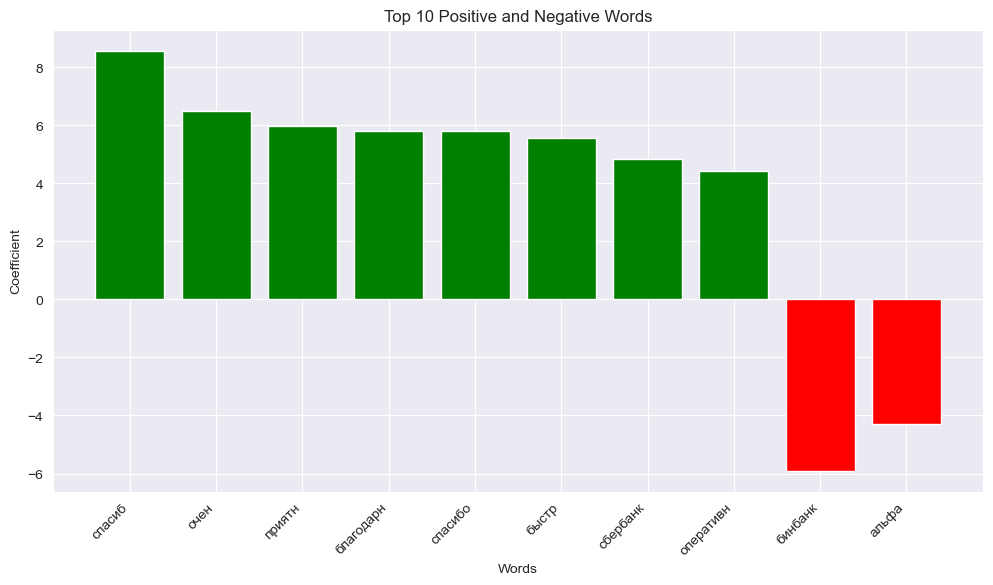

In [7]:
# Интерпретация результатов
# Вывод наиболее важных признаков (слов) для каждого класса
feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_[0]
sorted_coefs = sorted(zip(coefs, feature_names), key=lambda x: abs(x[0]), reverse=True)

# Вывод топ-10 положительных и отрицательных слов
print("Top 10 positive words:")
for coef, feature in sorted_coefs[:10]:
    if coef > 0:
        print(f"{feature}: {coef}")

print("\nTop 10 negative words:")
for coef, feature in sorted_coefs[:10]:
    if coef < 0:
        print(f"{feature}: {coef}")

# Визуализация важных признаков
# Пример: гистограмма топ-10 положительных и отрицательных слов
top_positive_words = [feature for coef, feature in sorted_coefs[:10] if coef > 0]
top_positive_coefs = [coef for coef, feature in sorted_coefs[:10] if coef > 0]
top_negative_words = [feature for coef, feature in sorted_coefs[:10] if coef < 0]
top_negative_coefs = [coef for coef, feature in sorted_coefs[:10] if coef < 0]

plt.figure(figsize=(12, 6))
plt.bar(top_positive_words, top_positive_coefs, color='green')
plt.bar(top_negative_words, top_negative_coefs, color='red')
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Positive and Negative Words")
plt.xlabel("Words")
plt.ylabel("Coefficient")
plt.show()


In [8]:

# Анализ ошибок
# Можно вывести примеры неправильно классифицированных отзывов для дальнейшего анализа и улучшения модели
incorrect_predictions = test_data[test_data['Score'] != predictions]
print("\nExamples of incorrect predictions:")
print(incorrect_predictions[['Text', 'Score']].head(10))


Examples of incorrect predictions:
                                                    Text     Score
9855   открыва вклад новогодн петербург московск фили...  Negative
6449   мил любим банк!т знаешь, тоб обща год впечатле...  Positive
13333  известно, человек - так существо, котор хорош ...  Positive
5757   мо сотрудничеств банк авангард продолжа двух л...  Negative
13018  здравствуйте. жив город пензе. 3 август 2014 г...  Positive
6437   добр день! 15 июн 2013 год оформ потребительск...  Positive
13079  декабр 2010 оформ кредитн продукт рефинансиров...  Positive
877    добр день! достаточн давн явля клиент банк акб...  Positive
3676   добр вечер. част польз кредитами, пользуюсь, о...  Negative
11206  хоч сказа огромн спасиб сотрудник кко саратов-...  Positive


confusion matrix для просмотра так ли точно работает модель



Confusion Matrix:
[[679  22]
 [ 50 666]]


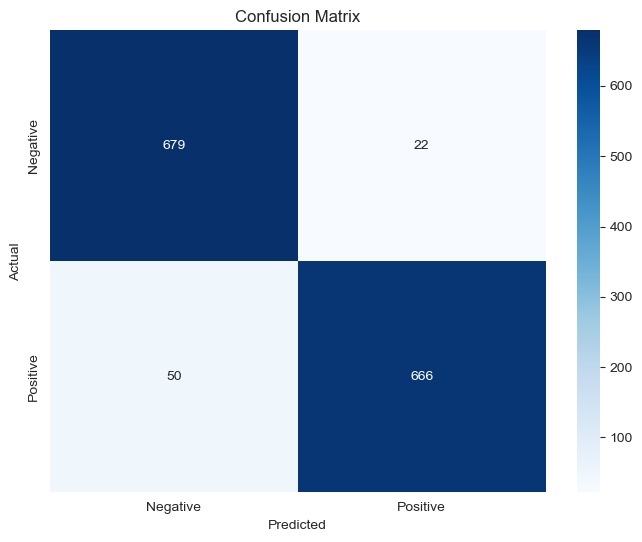

In [9]:
from sklearn.metrics import confusion_matrix

# Confusion matrix
cm = confusion_matrix(test_data['Score'], predictions)
print(f"Confusion Matrix:\n{cm}")

# Визуализация confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Negative', 'Positive'], 
            yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()